# Testing Ratings Classifier on Wind Station Data

This notebook is validating the accuracy of the previously-trained condition ratings model when substituting GFS wind data for SL wind station data.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb
import datetime as dt

from mlsurfzone.lotus_dataset import LotusDataset
from mlsurfzone.validate import plot_cm

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
ptf_cols = ['LotusSigH', 'LotusSigH_part1', 'LotusTp_part1',
            'LotusSpred_part1', 'LotusBreaking_part1', 'LotusPdir_norm_part1',
            'LotusSigH_part2', 'LotusTp_part2', 'LotusSpred_part2',
            'LotusBreaking_part2', 'LotusPdir_norm_part2',
            'LotusSigH_part3', 'LotusTp_part3', 'LotusSpred_part3',
            'LotusBreaking_part3', 'LotusPdir_norm_part3',
            'LotusSigH_part4', 'LotusTp_part4', 'LotusSpred_part4',
            'LotusBreaking_part4', 'LotusPdir_norm_part4',
            'GFS_wind_speed', 'GFS_wind_dir_norm', 'GFS_onshore_comp', 'GFS_crossshore_comp',
            'human_report_surf_max_ft', 
            'human_report_surf_condition_int']

In [3]:
def prepare_windstation_test_set(wind_type, csv_name, to_csv=False, keep_time=False):
        if keep_time:
            relevant_cols = ptf_cols + ['SpotId', 'valid_time', 'UnixTime']
        else:
            relevant_cols = ptf_cols
    
        wind_data = pd.read_csv(csv_name)
        wind_data['valid_time'] = wind_data.valid_time.astype(int)
        relevant = wind_data[['valid_time', 'wind_speed_ms',
                              'wind_gust_ms', 'wind_direction',
                              'SpotId', 'OptimalWindDirection',
                              'wind_speed', 'wind_dir_norm',
                              'onshore_comp', 'crossshore_comp']]
        
        test_data = pd.read_csv('../data/test.csv')
        test_data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'index'], inplace=True)
        
        merged = pd.merge_asof(test_data.sort_values(by='UnixTime'), relevant.sort_values(by='valid_time'),
                               left_on='UnixTime', right_on='valid_time',
                               tolerance=600)
        
        # merged.loc[np.isnan(merged['valid_time'])]
        windspots = wind_data.SpotId.unique()
        wind_test = merged.loc[merged['SpotId'].isin(windspots)]
        
        wind_test.dropna(subset=['OptimalWindDirection'], inplace=True)
        wind_test = wind_test.fillna(0)
        
        test_gfs = wind_test[relevant_cols]
        
        if to_csv:
            ptf_subset.to_csv('windstation_test_GFS.csv', index=False)
        
        # Replace GFS data columns with wind station data
        wind_test['GFS_wind_dir_norm'] = wind_test['wind_dir_norm']
        wind_test['GFS_wind_speed'] = wind_test['wind_speed']
        wind_test['GFS_onshore_comp'] = wind_test['onshore_comp']
        wind_test['GFS_crossshore_comp'] = wind_test['crossshore_comp']
        
        test_ws = wind_test[relevant_cols]
        if to_csv:
            test_ws.to_csv(f'windstation_test_{wind_type}.csv', index=False)
            
        return test_ws, test_gfs
        

---

## Validation!

In [4]:
gust, gfs = prepare_windstation_test_set('gust', 'ws_gust_test.csv')
speed, _ = prepare_windstation_test_set('speed', 'ws_speed_test.csv')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
# gfs = pd.read_csv('windstation_test_GFS.csv')
# ws = pd.read_csv('windstation_test.csv')

In [6]:
true = gfs['human_report_surf_condition_int']

In [7]:
gfs_dm = np.asarray(gfs.drop(columns=['human_report_surf_condition_int']))
gust_dm = np.asarray(gust.drop(columns=['human_report_surf_condition_int']))
speed_dm = np.asarray(speed.drop(columns=['human_report_surf_condition_int']))
gfs.shape, gust.shape, speed.shape

((4098, 27), (4098, 27), (4098, 27))

In [8]:
gfs_dm = xgb.DMatrix(gfs_dm, true)
gust_dm = xgb.DMatrix(gust_dm, true)
speed_dm = xgb.DMatrix(speed_dm, true)

In [9]:
bst = xgb.Booster()
bst.load_model('./model_files/ptfc_cond_ratings.model')

In [10]:
gfs_pred = bst.predict(gfs_dm)
gust_pred = bst.predict(gust_dm)
speed_pred = bst.predict(speed_dm)

In [11]:
bin_labels=['FLAT', 'VERY POOR', 'POOR', 
            'POOR TO FAIR','FAIR', 'FAIR TO GOOD',
            'GOOD', 'VERY GOOD', 'GOOD TO EPIC', 'EPIC']

In [12]:
gfs_pred.shape

(4098,)

Predictions on GFS wind

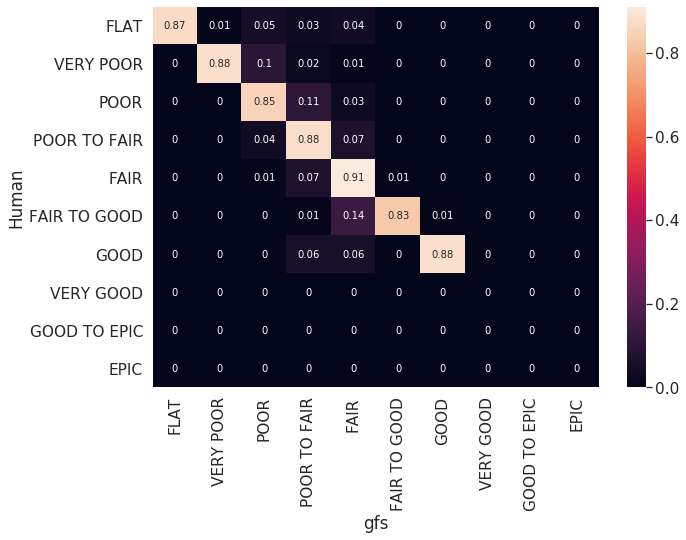

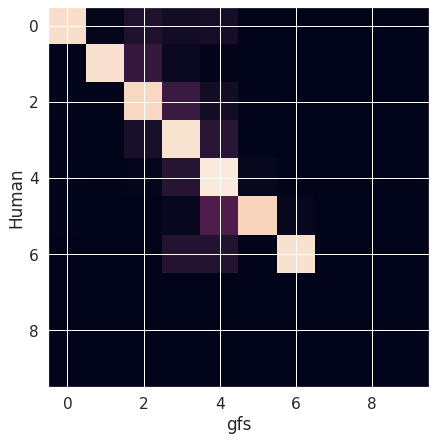

In [13]:
plot_cm(gfs_pred, true, normalize_over='true', name='gfs', bin_labels=bin_labels)

#### And with wind station data....

Predictions with gust data:

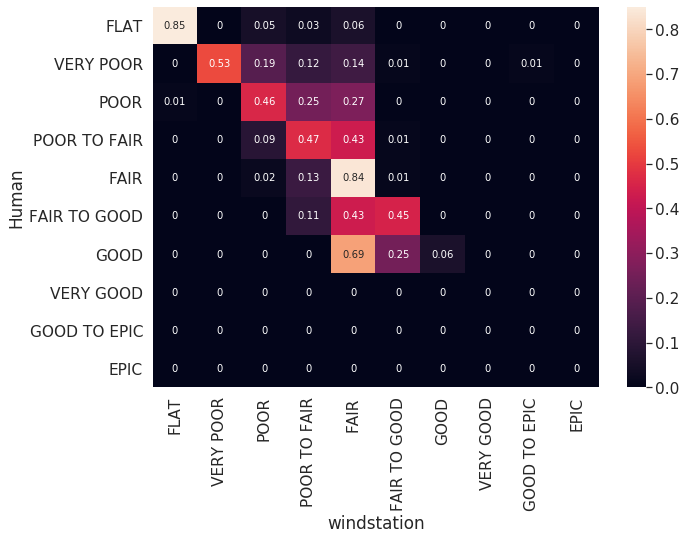

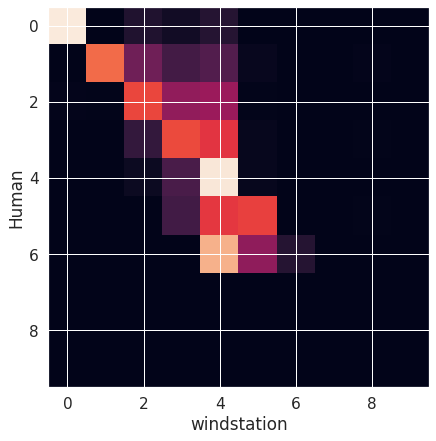

In [14]:
plot_cm(gust_pred, true, normalize_over='true', name='windstation', bin_labels=bin_labels)

Predictions with wind speed data:

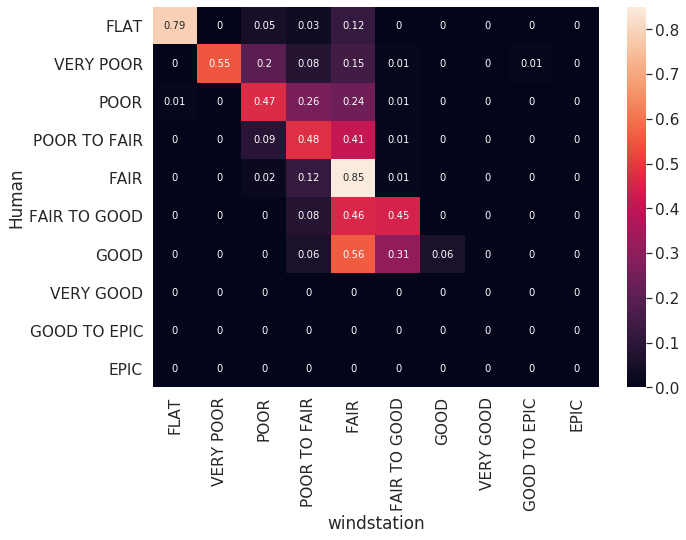

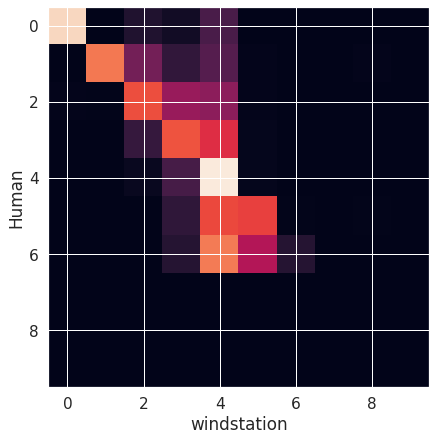

In [15]:
plot_cm(speed_pred, true, normalize_over='true', name='windstation', bin_labels=bin_labels)

## Compare GFS to wind station outputs

In [16]:
gust, gfs = prepare_windstation_test_set('gust', 'ws_gust_test.csv', keep_time=True)
speed, gfs = prepare_windstation_test_set('speed', 'ws_speed_test.csv', keep_time=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
gust.columns

Index(['LotusSigH', 'LotusSigH_part1', 'LotusTp_part1', 'LotusSpred_part1',
       'LotusBreaking_part1', 'LotusPdir_norm_part1', 'LotusSigH_part2',
       'LotusTp_part2', 'LotusSpred_part2', 'LotusBreaking_part2',
       'LotusPdir_norm_part2', 'LotusSigH_part3', 'LotusTp_part3',
       'LotusSpred_part3', 'LotusBreaking_part3', 'LotusPdir_norm_part3',
       'LotusSigH_part4', 'LotusTp_part4', 'LotusSpred_part4',
       'LotusBreaking_part4', 'LotusPdir_norm_part4', 'GFS_wind_speed',
       'GFS_wind_dir_norm', 'GFS_onshore_comp', 'GFS_crossshore_comp',
       'human_report_surf_max_ft', 'human_report_surf_condition_int', 'SpotId',
       'valid_time', 'UnixTime'],
      dtype='object')

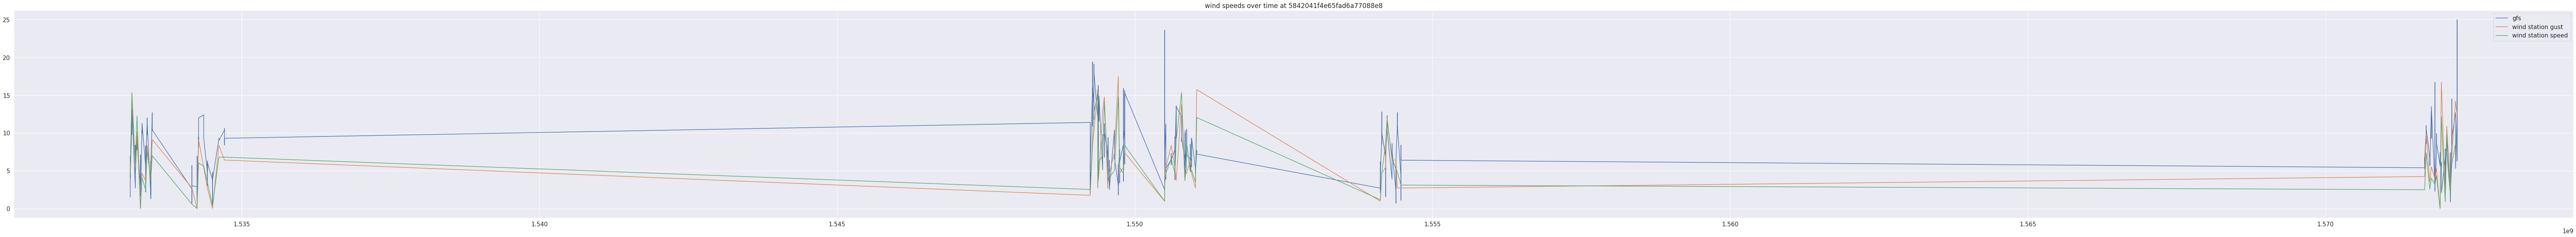

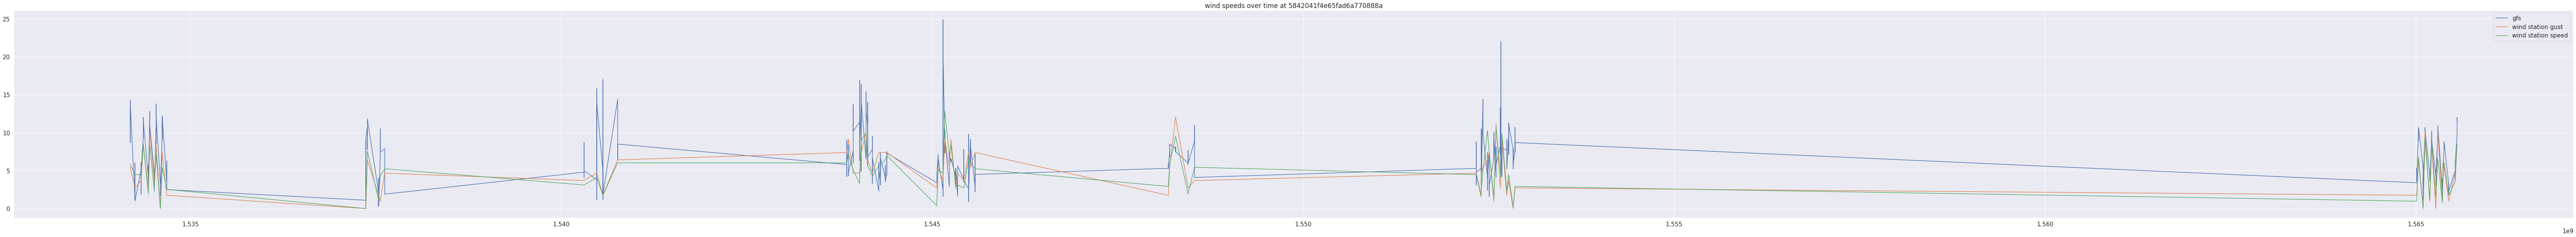

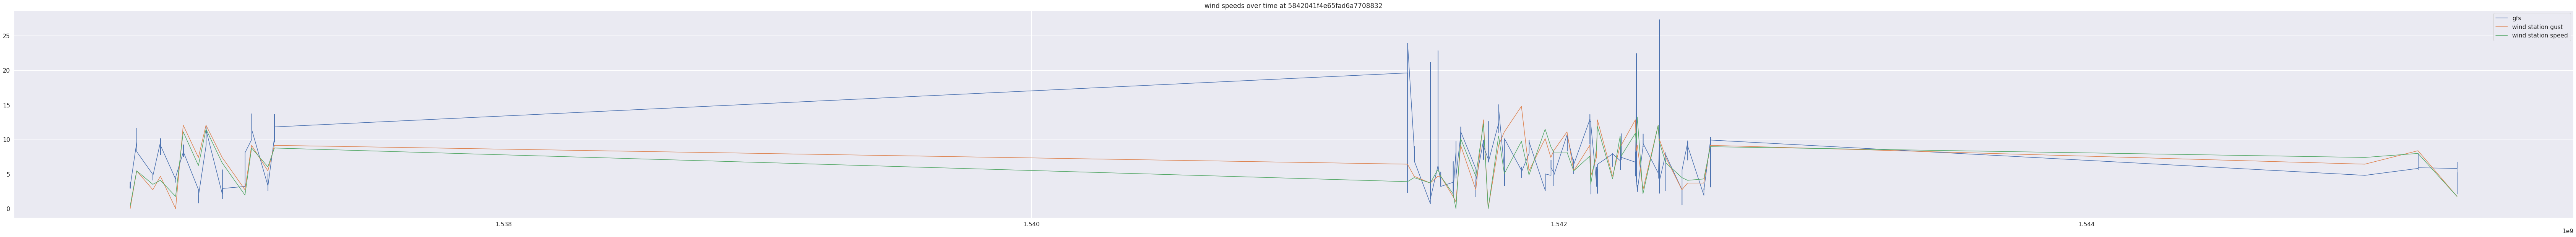

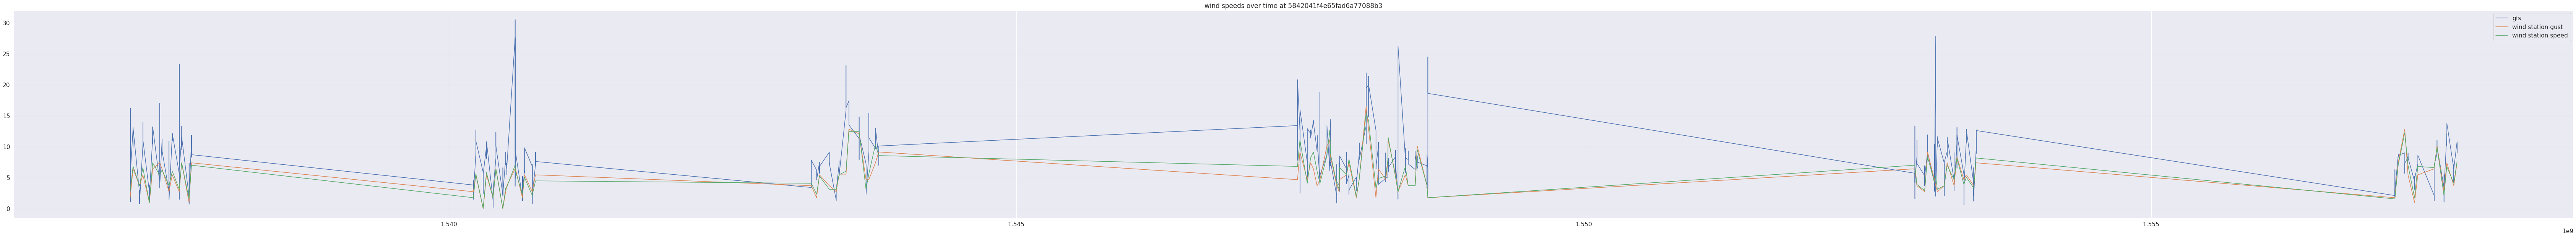

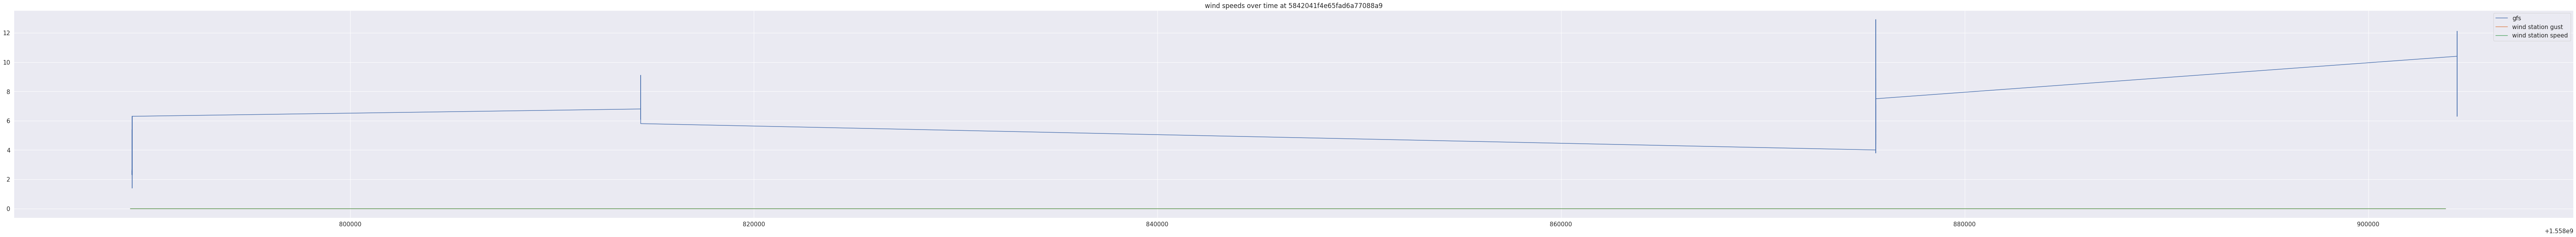

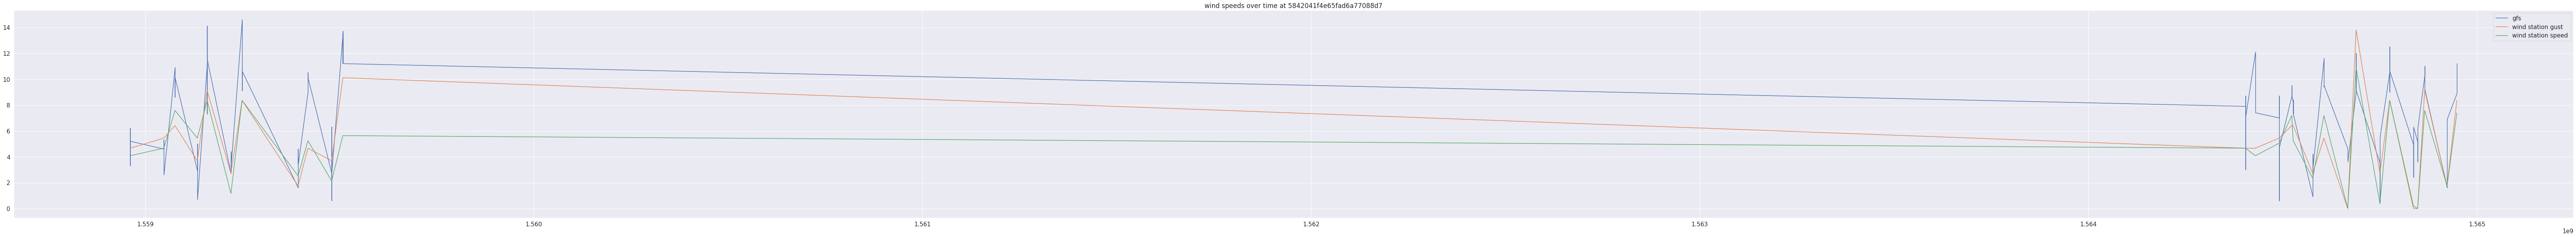

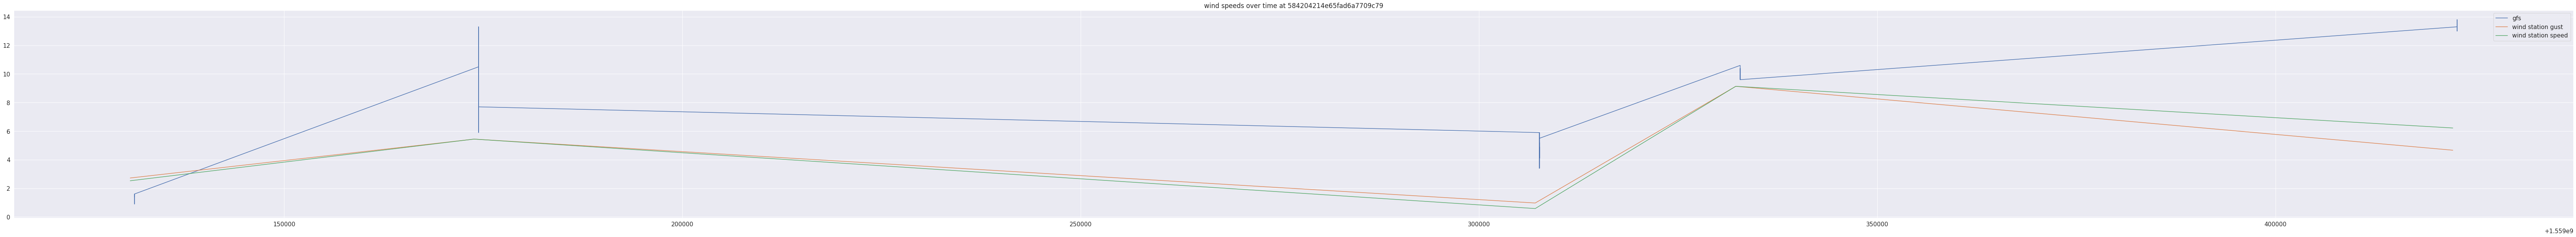

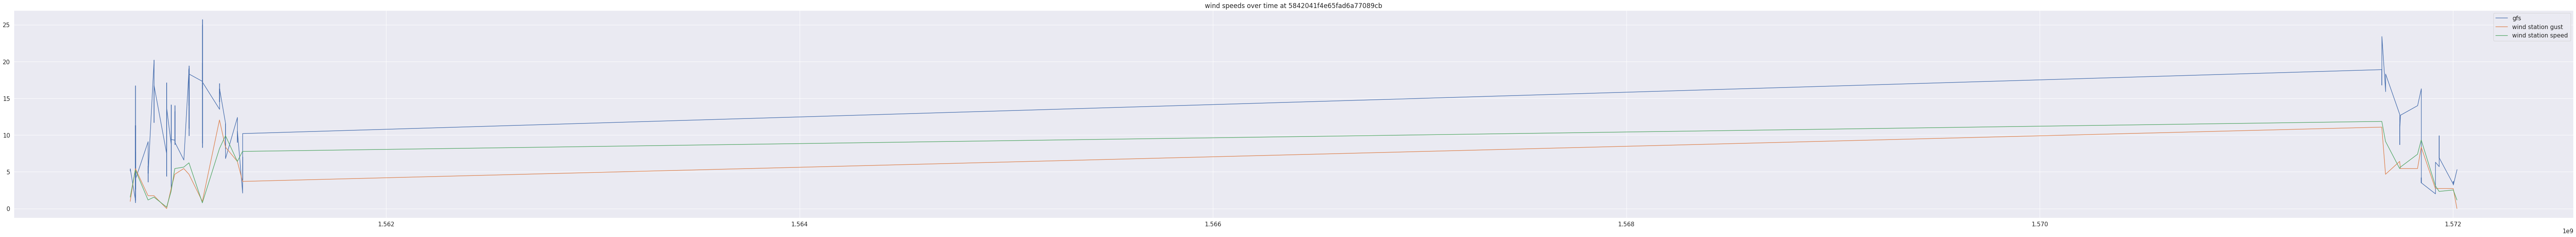

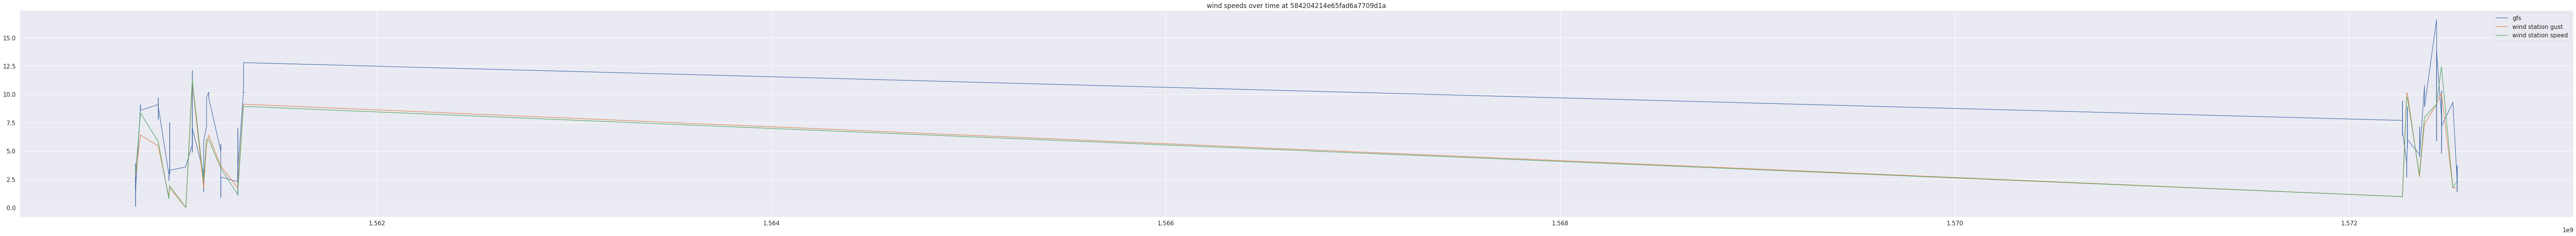

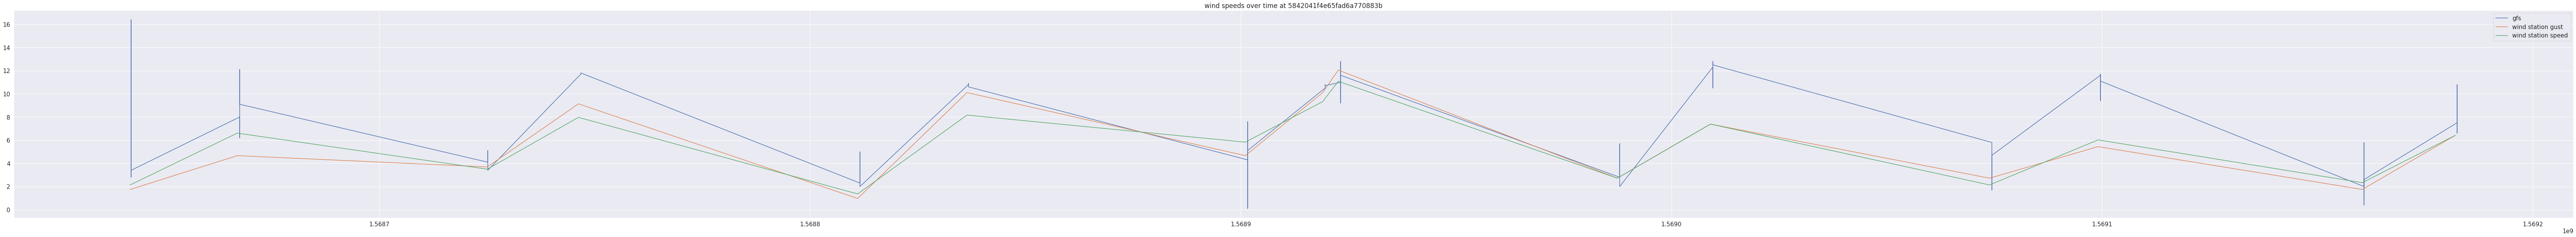

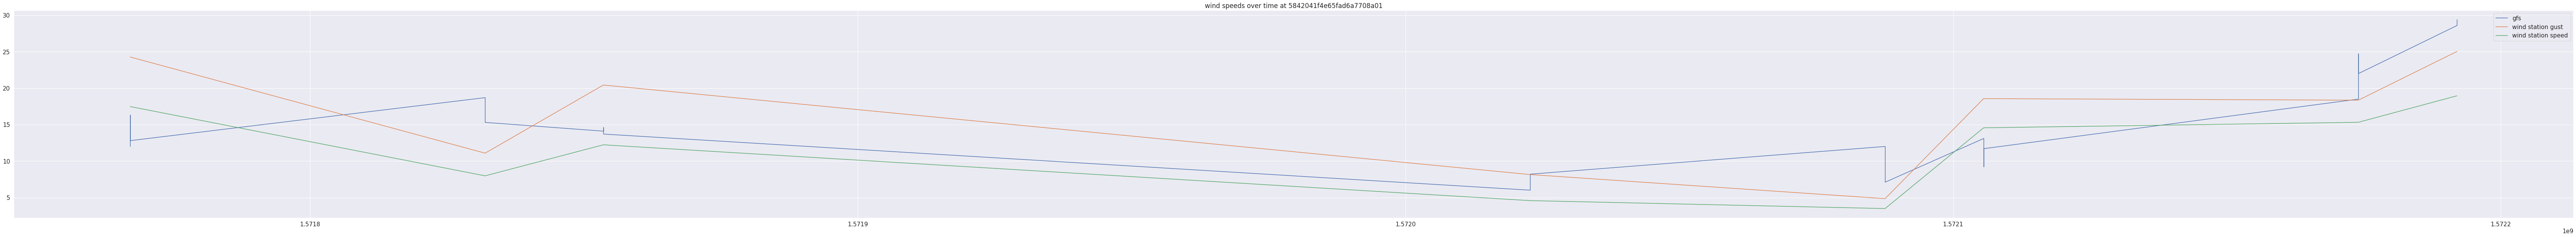

In [20]:
windspots = gfs.SpotId.unique()
for w in windspots:
    gu = gust.loc[gust['SpotId'] == w]
    s = speed.loc[speed['SpotId'] == w]
    gf = gfs.loc[gfs['SpotId'] == w]

    fig = plt.figure(figsize=(120,10))

    plt.plot(gf['UnixTime'], gf['GFS_wind_speed'], label='gfs')
    plt.plot(gu['valid_time'], gu['GFS_wind_speed'], label='wind station gust')
    plt.plot(s['valid_time'], s['GFS_wind_speed'], label='wind station speed')
    plt.title(f'wind speeds over time at {w}')
    plt.legend()
